# Library

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable
from dataclasses import dataclass
from pprint import pformat
# from loguru import logger
from pathlib import Path
import pandas as pd
from tqdm import tqdm

## Numpy set seed

In [1]:
np.random.seed(42)

NameError: name 'np' is not defined

## Part 1

In [2]:
# Load the npy file
# You can use numpy's load function to read .npy files
npy_data : np.ndarray= np.load('./weights.npy', allow_pickle=True)

In [3]:
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=0, keepdims=True))  # Numerical stability
    return exp_x / np.sum(exp_x, axis=0, keepdims=True)


def softmax_derivative(softmax_output):
    # The derivative of softmax is generally used with cross-entropy loss, but for this example:
    s = softmax_output.reshape(-1, 1)
    return np.diagflat(s) - np.dot(s, s.T)


In [4]:
class Tools:
    activate_funcs = {
        "sigmoid": (
            lambda x: 1 / (1 + np.exp(-x)),
            lambda x: 1 / (1 + np.exp(-x) ** 2),
        ),
        "relu": (lambda x: np.maximum(0, x), lambda x: np.where(x > 0, 1, 0)),
        "leaky_relu": (
            lambda x: np.where(x > 0, x, x * 0.01),
            lambda x: np.where(x > 0, 1, 0.01),
        ),
        "tanh": (lambda x: np.tanh(x), lambda x: 1 - np.tanh(x) ** 2),
        "linear": (lambda x: x, lambda x: 1),
        "softmax": (
            lambda x: np.clip(softmax(x), 1e-15, 1 - 1e-15),
            softmax_derivative,
        ),
    }

    loss_funcs = {
        "sse": (
            lambda y, y_hat: np.sum((y - y_hat) ** 2),
            lambda y, y_hat: -2 * (y - y_hat),
        ),
        "rms": (
            lambda y, y_hat: np.sqrt(np.mean((y - y_hat) ** 2)),
            lambda y, y_hat: -(y - y_hat) / (len(y) * np.sqrt(np.sum((y - y_hat) ** 2))),
        ),
        "crossentropy": (
            lambda y, y_hat: -np.sum(y * np.log(y_hat)),
            lambda y, y_hat: y_hat - y,
        )
    }

    @staticmethod
    def activate_func(name: str) -> tuple[Callable, Callable]:
        return Tools.activate_funcs[name]

    @staticmethod
    def loss_func(name: str) -> tuple[Callable, Callable]:
        return Tools.loss_funcs[name]

    @staticmethod
    def rms(y_true: np.ndarray, y_hat: np.ndarray) -> float:
        return np.sqrt(np.mean(np.sum(y_true - y_hat) ** 2))

In [5]:
@dataclass
class Layer:
    input_node: int
    activate: str
    output_node: int
    dropout_rate: float = 0.0
    zero:bool = False


@dataclass
class BaseModelLayer:
    w: np.ndarray
    b: np.ndarray

    @classmethod
    def zero_like(cls, layer_basic):
        w = np.zeros_like(layer_basic.w)
        b = np.zeros_like(layer_basic.b)
        return cls(w, b)

    @property
    def shape(self) -> dict:
        return {"w": self.w.shape, "b": self.b.shape}

In [6]:

@dataclass
class ModelLayer(BaseModelLayer):
    activate_str: str
    activate: Callable[[np.ndarray], np.ndarray]
    activate_derivative: Callable[[np.ndarray], np.ndarray]
    dropout_rate: float

    @classmethod
    def load_weights(cls, w:np.ndarray, b:np.ndarray, activate_str:str, dropout_rate: float = 0.0):
        activate, activate_derivative = Tools.activate_func(activate_str)
        
        return cls(
            w=w,
            b=b,
            dropout_rate=dropout_rate,
            activate_str=activate_str,
            activate=activate,
            activate_derivative=activate_derivative
        )
    
    @classmethod
    def build_layer(cls, layer_config: Layer):
        if not (0 <= layer_config.dropout_rate < 1):
            raise ValueError("dropout_rate must between 0 and 1")

        w = np.random.randn(layer_config.output_node, layer_config.input_node)
        b = np.random.randn(layer_config.output_node, 1)
        
        w, b = (
            w * np.sqrt(1.0 / layer_config.input_node),
            b * 0.01,
        )
        
        if layer_config.zero:
            w, b = np.zeros_like(w), np.zeros_like(b)
        
        activate, activate_derivative = Tools.activate_func(layer_config.activate)
        return cls(
            w=w,
            b=b,
            dropout_rate=layer_config.dropout_rate,
            activate_str=layer_config.activate,
            activate=activate,
            activate_derivative=activate_derivative,
        )

    def forward_drop_out(self, a: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        mask = np.random.binomial(1, 1 - self.dropout_rate, size=a.shape)
        a_drop_out = (a * mask) / (1 - self.dropout_rate)
        return a_drop_out, mask

    def update_delta(
        self,
        delta: np.ndarray,
        layer_next,
        z_next: np.ndarray,
        mask: np.ndarray = None,
    ) -> np.ndarray:

        if mask is not None:
            delta *= mask

        return (self.w.T @ delta) * layer_next.activate_derivative(z_next)

    def update(self, grad_item: BaseModelLayer, lr: float) -> None:
        assert (
            self.w.shape == grad_item.w.shape
        ), f"权重形状不匹配: {self.w.shape} vs {grad_item.w.shape}"
        assert self.b.shape[1] == 1

        assert (
            self.b.shape == grad_item.b.shape
        ), f"偏置形状不匹配: {self.b.shape} vs {grad_item.b.shape} {grad_item.w.shape}"

        self.w -= lr * grad_item.w
        self.b -= lr * grad_item.b
        return

    def __call__(self, x: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        z = self.w @ x + self.b
        a = self.activate(z)
        return z, a

    def __str__(self) -> str:
        return f"w: {self.w.shape}, b: {self.b.shape}, activate: {self.activate_str}"

    def __repr__(self) -> str:
        return self.__str__()

In [ ]:

class DNN:
    def __init__(self, layers_config: list[Layer | ModelLayer], loss_func: str = "sse"):
        
        self._input_dim, self._output_dim, self._layers = DNN._dim_layers(layers_config)

        self._layers_len = len(self._layers)

        self._loss_func, self._loss_derivative = Tools.loss_func(loss_func)

        # self._is_multi = self._output_dim > 1

        self._model_struct = {
            "input_dim": self._input_dim,
            "output_dim": self._output_dim,
            "hidden_layers": self._layers,
            "loss_func": loss_func,
        }

        return
    @staticmethod
    def _dim_layers(layers_config: list[Layer | ModelLayer]) -> tuple[int, int, dict[int, ModelLayer]]:
        sample = layers_config[0]
        input_dim , output_dim = None, None
        
        layers = {}
        
        if isinstance(sample, Layer):
            input_dim , output_dim = (
                layers_config[0].input_node,
                layers_config[-1].output_node,
            )
            
            layers = {
                i: ModelLayer.build_layer(layer)
                for i, layer in enumerate(layers_config, start=1)
            }
            
        elif isinstance(sample, ModelLayer):
            input_dim , output_dim = (
                layers_config[0].w.shape[1],
                layers_config[-1].w.shape[0],
            )
            
            layers = {
                i: layer
                for i, layer in enumerate(layers_config, start=1)
            }

        return input_dim, output_dim, layers 
    
    @property
    def model_struct(self):
        return self._model_struct

    @property
    def w(self):
        return self._w

    @property
    def b(self):
        return self._b

    def forward(
        self, x: np.ndarray, for_backward: bool = False
    ) -> (
        tuple[dict[int, np.ndarray], dict[int, np.ndarray], dict[int, np.ndarray]]
        | np.ndarray
    ):

        if len(x.shape) == 1:
            x = x[:, np.newaxis]

        a_out, z_out, mask_out = {0: x}, dict(), dict()

        for i, layer in self._layers.items():
            z_out[i], a_out[i] = layer(a_out[i - 1])

            if layer.dropout_rate > 0 and for_backward:
                a_out[i], mask_out[i] = layer.forward_drop_out(a_out[i])

        last_item = next(reversed(a_out.values()))

        if for_backward:
            return last_item, a_out, z_out, mask_out

        return last_item

    def init_delta(self, a_out: np.ndarray, y: np.ndarray) -> np.ndarray:
        # if self._is_multi:

        #     return self._loss_derivative(y, softmax(a_out)) / y.shape[1]
        # print(y.shape)
        return self._loss_derivative(y, a_out) / y.shape[1]

    def backward(
        self,
        end_y_hat: np.ndarray,
        a_out: dict[int, np.ndarray],
        z_out: dict[int, np.ndarray],
        mask_out: dict[int, np.ndarray],
        y: np.ndarray,
    ) -> dict[int, BaseModelLayer]:
        # https://medium.com/@erikhallstrm/backpropagation-from-the-beginning-77356edf427d
        """
        put y data is a column vector , so if data is row vector , please transpose
        """
        grad = {i: BaseModelLayer.zero_like(layer) for i, layer in self._layers.items()}

        # init the delta
        delta = self.init_delta(end_y_hat, y)
        # print({"delta": delta, "y_hat": end_y_hat, "y": y})

        for layer_index in reversed(self._layers.keys()):
            next_index = layer_index - 1

            grad[layer_index].w = delta @ a_out[next_index].T

            grad[layer_index].b = np.sum(delta, axis=1, keepdims=True)

            if layer_index > 1:
                delta = self._layers[layer_index].update_delta(
                    delta=delta,
                    mask=mask_out.get(layer_index, None),
                    layer_next=self._layers[next_index],
                    z_next=z_out[next_index],
                )

        return grad

    def _update(self, grad: dict[int, BaseModelLayer], learning_rate: float) -> None:
        for i, grad_item in grad.items():
            self._layers[i].update(grad_item, lr=learning_rate)

        return

    def __call__(self, x) -> np.ndarray:
        return self.forward(x.T, for_backward=False)

    def __str__(self) -> str:
        return pformat(self._model_struct)

    def _l2_regularization(self, lambda_reg: float = 0.01):
        weight_item = [np.sum(np.square(layer.w)) for layer in self._layers.values()]
        return lambda_reg * 0.5 * np.sum(weight_item)

    def evaluate(self, x: np.ndarray, y: np.ndarray) -> tuple[float, float]:
        y_hat = self.forward(x.T, for_backward=False)
        loss = self._loss_func(y.T, y_hat)
        acc = np.mean(np.argmax(y.T, axis=0) == np.argmax(y_hat, axis=0))
        return loss, acc
    
    
    def train(
        self,
        x: np.ndarray,
        y: np.ndarray,
        epochs: int,
        batch_size: int,
        learning_rate: float,
        l2: float = 0,
        save_folder: str = None,
        open_shuffle: bool = True,
        addition_check_data:dict[str,np.ndarray] = None
    ) -> None:
        loss_log = []

        for epoch in range(epochs):
            X_shuffled = x
            y_shuffled = y

            if open_shuffle:
                indices = np.random.permutation(x.shape[0])
                X_shuffled = x[indices]
                y_shuffled = y[indices]                

            for i in tqdm(range(0, X_shuffled.shape[0], batch_size), desc=f"epoch {epoch}"):
            # for i in range(0, X_shuffled.shape[0], batch_size):
                

                X_batch = X_shuffled[i : i + batch_size]
                Y_batch = y_shuffled[i : i + batch_size]

                x_batch = X_batch.T
                y_batch = Y_batch.T

                y_hat, a_out, z_out, mask_out = self.forward(x_batch, for_backward=True)

                loss = self._loss_func(y_batch, y_hat)
                grad = self.backward(y_hat, a_out, z_out, mask_out, y_batch)
                
                acc = np.mean(np.argmax(y_batch, axis=0) == np.argmax(y_hat, axis=0))

                if l2:
                    loss += self._l2_regularization(l2)

                    # update grad with l2
                    for i in grad.keys():
                        grad[i].w += l2 * self._layers[i].w

                # update
                self._update(grad, learning_rate)

                loss_log.append({"epoch": epoch, "training_loss": loss, "training_acc": acc})
                
                if addition_check_data:
                    x_check = addition_check_data["x"]
                    y_check = addition_check_data["y"]
                    loss_check, acc_check = self.evaluate(x_check, y_check)
                    loss_log[-1]["test_loss"] = loss_check
                    loss_log[-1]["test_acc"] = acc_check

                
            # evaluate
            train_loss, train_acc = self.evaluate(x, y)
            evaluate_dict = {
                "test_loss": train_loss,
                "test_acc": train_acc,
            }
            
            if addition_check_data:
                test_loss, test_acc = self.evaluate(addition_check_data["x"], addition_check_data["y"])
                evaluate_dict |= {"test_loss": test_loss,"test_acc": test_acc}
                
            print(f"epoch {epoch}: {evaluate_dict}")

        if save_folder is not None:
            path = Path(save_folder)
            path.mkdir(parents=True, exist_ok=True)

            df_log = pd.DataFrame(loss_log)
            df_log.to_csv(path.joinpath("loss_acc.csv"), index=False)

            plt.figure(figsize=(8, 6))
            plt.plot(df_log.index, df_log["training_loss"], marker="o", label="Training Loss")
            
            if addition_check_data:
                plt.plot(df_log.index, df_log["test_loss"], marker="x", label="Test Loss")

            # Labeling the plot
            plt.xlabel("Index")
            plt.ylabel("Loss")
            plt.title("Loss vs. Index")
            plt.legend()
            plt.savefig(path / "loss.png")

            plt.clf()
            
            plt.figure(figsize=(8, 6))
            plt.plot(df_log.index, df_log["training_acc"], marker="o", label="Training Acc")
            
            if addition_check_data:
                plt.plot(df_log.index, df_log["test_acc"], marker="x", label="Test Acc")
            

            # Labeling the plot
            plt.xlabel("Index")
            plt.ylabel("Acc")
            plt.title("Acc vs. Index")
            plt.legend()
            plt.savefig(path / "acc.png")
            
            print(f"save to {path}")

        return

    @classmethod
    def lazy_build(
        cls,
        input_dim: int,
        output_dim: int,
        calculate_layers: int,
        activate_func: str,
        up_dim: int,
        loss_func: str = "sse",
    ):

        lazy_config = (
            [Layer(input_node=input_dim, output_node=up_dim, activate=activate_func)]
            + [
                Layer(input_node=up_dim, output_node=up_dim, activate=activate_func)
                for _ in range(calculate_layers - 2)
            ]
            + [Layer(input_node=up_dim, output_node=output_dim, activate=activate_func)]
        )

        return cls(lazy_config, loss_func)

In [8]:
class Fnn(DNN):
    def __init__(self, layers_config: list[Layer | ModelLayer], loss_func: str = "sse"):
        super().__init__(layers_config, loss_func)
        return
    
    @staticmethod
    def load_weights(path: str, loss_func: str = "crossentropy", activation:str | list[str] | None = None, dtype=np.float64):
        model_weight = np.load(path, allow_pickle=True)
        
        model_dict = {
            key : model_weight.item()[key] 
            for key in model_weight.item()
        }
        
        activation = activation if activation else ["relu"] * 3
        
        if isinstance(activation, str):
            activation = [activation] * 3
        
        layers_config = [
            ModelLayer.load_weights(
                w=model_dict[f"w{i}"].T.astype(dtype),
                b=model_dict[f"b{i}"].astype(dtype),
                activate_str=activation[i-1],
            )
            for i in range(1, 4)
        ]
        
        
        return Fnn(layers_config, loss_func)
        

In [9]:
model = Fnn.load_weights(
    './weights.npy',
    activation=[
        "relu",
        "relu",
        "softmax"
    ],
    dtype=np.float32
)

In [10]:
print(model)

{'hidden_layers': {1: w: (2048, 784), b: (2048, 1), activate: relu,
                   2: w: (512, 2048), b: (512, 1), activate: relu,
                   3: w: (10, 512), b: (10, 1), activate: softmax},
 'input_dim': 784,
 'loss_func': 'crossentropy',
 'output_dim': 10}


In [11]:
DATA_FOLDER = Path("./fashion")

In [12]:
dataset = {
    key : (np.load(DATA_FOLDER / f"{key}_x.npy"), np.load(DATA_FOLDER / f"{key}_y.npy"))
    for key in ["train", "test"]
}

In [13]:
dataset["train"][0].shape, dataset["train"][1].shape

((60000, 28, 28), (60000,))

In [14]:
# Reshape the training data from (60000, 28, 28) to (60000, 784)
x_train = dataset["train"][0].reshape(dataset["train"][0].shape[0], -1).astype(np.float32)
y_train = dataset["train"][1].reshape(dataset["train"][1].shape[0], -1).astype(np.float32)

x_test = dataset["test"][0].reshape(dataset["test"][0].shape[0], -1).astype(np.float32)
y_test = dataset["test"][1].reshape(dataset["test"][1].shape[0], -1).astype(np.float32)

In [15]:
print(f"X_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

print(f"X_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (60000, 784)
y_train shape: (60000, 1)
X_test shape: (10000, 784)
y_test shape: (10000, 1)


In [16]:
x_train = x_train / 255.0
x_test = x_test / 255.0

In [17]:
# Define the number of classes (assuming digit labels 0-9)
num_classes = 10

# One-hot encode y_train and y_test
y_train = np.eye(num_classes)[y_train.astype(np.int32).reshape(-1)].astype(np.float32)
y_test = np.eye(num_classes)[y_test.astype(np.int32).reshape(-1)].astype(np.float32)

print("y_train one-hot encoded shape:", y_train.shape)
print("y_test one-hot encoded shape:", y_test.shape)

y_train one-hot encoded shape: (60000, 10)
y_test one-hot encoded shape: (10000, 10)


## Question 1 

In [18]:
base_train_conf = {
    "x": x_train,
    "y": y_train,
    "epochs": 30,
    "batch_size": 200,
    "learning_rate": 0.005,
    # "save_folder": "./fashion",
}

In [19]:
config = base_train_conf | {"open_shuffle": False, "save_folder": "./fashion_logs"}

epoch 0: 100%|██████████| 300/300 [00:13<00:00, 22.54it/s]


epoch 0, loss 318568.84375, acc 0.7656333333333334


epoch 1: 100%|██████████| 300/300 [00:12<00:00, 23.23it/s]


epoch 1, loss 222663.171875, acc 0.7307833333333333


epoch 2: 100%|██████████| 300/300 [00:12<00:00, 23.67it/s]


epoch 2, loss 160208.625, acc 0.7367333333333334


epoch 3: 100%|██████████| 300/300 [00:12<00:00, 23.61it/s]


epoch 3, loss 134230.25, acc 0.7375166666666667


epoch 4: 100%|██████████| 300/300 [00:12<00:00, 23.58it/s]


epoch 4, loss 118643.65625, acc 0.7409166666666667


epoch 5: 100%|██████████| 300/300 [00:12<00:00, 23.47it/s]


epoch 5, loss 105311.1796875, acc 0.7486666666666667


epoch 6: 100%|██████████| 300/300 [00:12<00:00, 23.67it/s]


epoch 6, loss 95581.7421875, acc 0.7522333333333333


epoch 7: 100%|██████████| 300/300 [00:12<00:00, 23.75it/s]


epoch 7, loss 87910.265625, acc 0.7534


epoch 8: 100%|██████████| 300/300 [00:12<00:00, 23.74it/s]


epoch 8, loss 81798.1171875, acc 0.7566833333333334


epoch 9: 100%|██████████| 300/300 [00:12<00:00, 23.62it/s]


epoch 9, loss 76720.1640625, acc 0.7616


epoch 10: 100%|██████████| 300/300 [00:12<00:00, 23.82it/s]


epoch 10, loss 72145.953125, acc 0.7673333333333333


epoch 11: 100%|██████████| 300/300 [00:12<00:00, 23.62it/s]


epoch 11, loss 68619.9453125, acc 0.77255


epoch 12: 100%|██████████| 300/300 [00:12<00:00, 23.36it/s]


epoch 12, loss 65160.90234375, acc 0.7752833333333333


epoch 13: 100%|██████████| 300/300 [00:12<00:00, 23.78it/s]


epoch 13, loss 62188.359375, acc 0.77975


epoch 14: 100%|██████████| 300/300 [00:12<00:00, 23.73it/s]


epoch 14, loss 59773.08984375, acc 0.7836666666666666


epoch 15: 100%|██████████| 300/300 [00:12<00:00, 23.14it/s]


epoch 15, loss 57588.54296875, acc 0.78605


epoch 16: 100%|██████████| 300/300 [00:12<00:00, 23.67it/s]


epoch 16, loss 55296.546875, acc 0.7893833333333333


epoch 17: 100%|██████████| 300/300 [00:12<00:00, 23.84it/s]


epoch 17, loss 53533.96484375, acc 0.79205


epoch 18: 100%|██████████| 300/300 [00:12<00:00, 23.83it/s]


epoch 18, loss 51627.7109375, acc 0.7946666666666666


epoch 19: 100%|██████████| 300/300 [00:12<00:00, 23.83it/s]


epoch 19, loss 49948.66015625, acc 0.7971666666666667


epoch 20: 100%|██████████| 300/300 [00:12<00:00, 23.45it/s]


epoch 20, loss 48576.95703125, acc 0.7987333333333333


epoch 21: 100%|██████████| 300/300 [00:12<00:00, 23.20it/s]


epoch 21, loss 46945.78515625, acc 0.8009166666666667


epoch 22: 100%|██████████| 300/300 [00:12<00:00, 23.87it/s]


epoch 22, loss 45718.2578125, acc 0.8026666666666666


epoch 23: 100%|██████████| 300/300 [00:12<00:00, 24.00it/s]


epoch 23, loss 44621.8046875, acc 0.8043833333333333


epoch 24: 100%|██████████| 300/300 [00:12<00:00, 24.06it/s]


epoch 24, loss 43437.55859375, acc 0.8062833333333334


epoch 25: 100%|██████████| 300/300 [00:12<00:00, 24.02it/s]


epoch 25, loss 42463.75390625, acc 0.8077666666666666


epoch 26: 100%|██████████| 300/300 [00:12<00:00, 23.89it/s]


epoch 26, loss 41401.17578125, acc 0.8103666666666667


epoch 27: 100%|██████████| 300/300 [00:12<00:00, 24.04it/s]


epoch 27, loss 40532.4765625, acc 0.8117833333333333


epoch 28: 100%|██████████| 300/300 [00:12<00:00, 23.42it/s]


epoch 28, loss 39583.8671875, acc 0.8134166666666667


epoch 29: 100%|██████████| 300/300 [00:12<00:00, 23.78it/s]


epoch 29, loss 38791.8515625, acc 0.8146166666666667
save to fashion_logs


<Figure size 800x600 with 0 Axes>

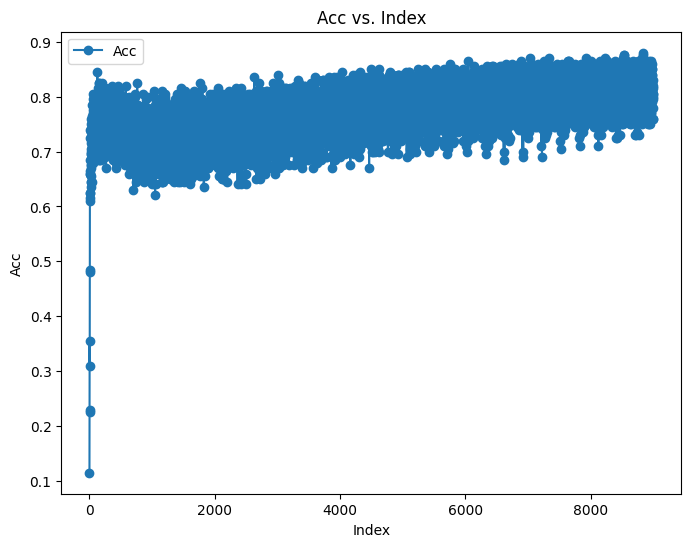

In [20]:
model.train(**config)

In [25]:
model_zero = DNN(
    layers_config=[
        Layer(input_node=784, output_node=2048, activate="relu", zero=True),
        Layer(input_node=2048, output_node=512, activate="relu", zero=True),
        Layer(input_node=512, output_node=10, activate="softmax", zero=True),  # Assuming binary classification
    ],
    loss_func="crossentropy",
)

In [26]:
print(model_zero)

{'hidden_layers': {1: w: (2048, 784), b: (2048, 1), activate: relu,
                   2: w: (512, 2048), b: (512, 1), activate: relu,
                   3: w: (10, 512), b: (10, 1), activate: softmax},
 'input_dim': 784,
 'loss_func': 'crossentropy',
 'output_dim': 10}


In [27]:
config = base_train_conf | {"open_shuffle": False, "save_folder": "./fashion_zero_logs"}

epoch 0: 100%|██████████| 300/300 [00:09<00:00, 32.52it/s]


epoch 0, loss 138155.10576878325, acc 0.1


epoch 1: 100%|██████████| 300/300 [00:09<00:00, 32.91it/s]


epoch 1, loss 138155.1062344578, acc 0.1


epoch 2: 100%|██████████| 300/300 [00:09<00:00, 31.89it/s]


epoch 2, loss 138155.1068596073, acc 0.1


epoch 3: 100%|██████████| 300/300 [00:09<00:00, 32.68it/s]


epoch 3, loss 138155.1075638445, acc 0.1


epoch 4: 100%|██████████| 300/300 [00:09<00:00, 32.83it/s]


epoch 4, loss 138155.1082930643, acc 0.1


epoch 5: 100%|██████████| 300/300 [00:09<00:00, 32.91it/s]


epoch 5, loss 138155.10901187087, acc 0.1


epoch 6: 100%|██████████| 300/300 [00:09<00:00, 33.01it/s]


epoch 6, loss 138155.1096980745, acc 0.1


epoch 7: 100%|██████████| 300/300 [00:09<00:00, 32.90it/s]


epoch 7, loss 138155.1103387065, acc 0.1


epoch 8: 100%|██████████| 300/300 [00:09<00:00, 32.76it/s]


epoch 8, loss 138155.11092714485, acc 0.1


epoch 9: 100%|██████████| 300/300 [00:09<00:00, 32.86it/s]


epoch 9, loss 138155.1114610529, acc 0.1


epoch 10: 100%|██████████| 300/300 [00:09<00:00, 32.04it/s]


epoch 10, loss 138155.11194091095, acc 0.1


epoch 11: 100%|██████████| 300/300 [00:09<00:00, 33.11it/s]


epoch 11, loss 138155.11236897722, acc 0.1


epoch 12: 100%|██████████| 300/300 [00:09<00:00, 32.97it/s]


epoch 12, loss 138155.11274856233, acc 0.1


epoch 13: 100%|██████████| 300/300 [00:09<00:00, 32.99it/s]


epoch 13, loss 138155.11308352795, acc 0.1


epoch 14: 100%|██████████| 300/300 [00:09<00:00, 33.01it/s]


epoch 14, loss 138155.11337794774, acc 0.1


epoch 15: 100%|██████████| 300/300 [00:09<00:00, 32.95it/s]


epoch 15, loss 138155.11363588346, acc 0.1


epoch 16: 100%|██████████| 300/300 [00:09<00:00, 33.07it/s]


epoch 16, loss 138155.11386124237, acc 0.1


epoch 17: 100%|██████████| 300/300 [00:09<00:00, 32.80it/s]


epoch 17, loss 138155.114057692, acc 0.1


epoch 18: 100%|██████████| 300/300 [00:09<00:00, 32.02it/s]


epoch 18, loss 138155.1142286152, acc 0.1


epoch 19: 100%|██████████| 300/300 [00:09<00:00, 33.02it/s]


epoch 19, loss 138155.1143770903, acc 0.1


epoch 20: 100%|██████████| 300/300 [00:09<00:00, 33.00it/s]


epoch 20, loss 138155.11450589084, acc 0.1


epoch 21: 100%|██████████| 300/300 [00:09<00:00, 32.70it/s]


epoch 21, loss 138155.11461749577, acc 0.1


epoch 22: 100%|██████████| 300/300 [00:09<00:00, 33.05it/s]


epoch 22, loss 138155.1147141065, acc 0.1


epoch 23: 100%|██████████| 300/300 [00:09<00:00, 33.01it/s]


epoch 23, loss 138155.11479766815, acc 0.1


epoch 24: 100%|██████████| 300/300 [00:09<00:00, 32.91it/s]


epoch 24, loss 138155.11486989236, acc 0.1


epoch 25: 100%|██████████| 300/300 [00:09<00:00, 32.94it/s]


epoch 25, loss 138155.11493227954, acc 0.1


epoch 26: 100%|██████████| 300/300 [00:09<00:00, 32.75it/s]


epoch 26, loss 138155.11498614185, acc 0.1


epoch 27: 100%|██████████| 300/300 [00:09<00:00, 32.26it/s]


epoch 27, loss 138155.11503262364, acc 0.1


epoch 28: 100%|██████████| 300/300 [00:09<00:00, 32.97it/s]


epoch 28, loss 138155.11507272112, acc 0.1


epoch 29: 100%|██████████| 300/300 [00:09<00:00, 33.02it/s]


epoch 29, loss 138155.11510730002, acc 0.1
save to fashion_zero_logs


<Figure size 800x600 with 0 Axes>

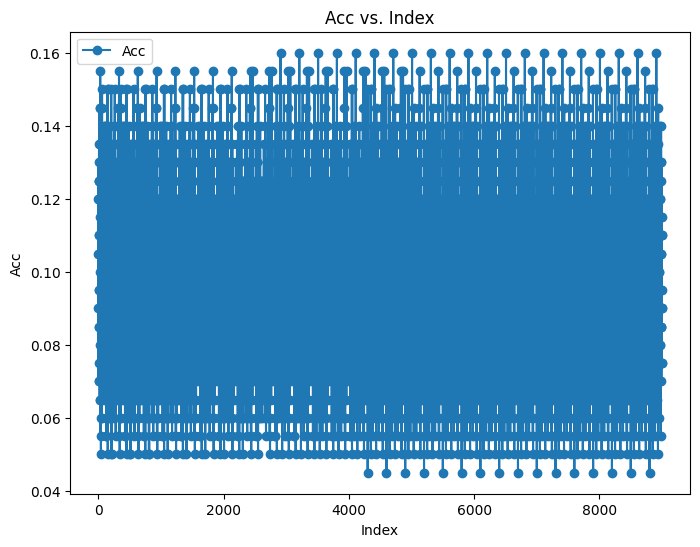

In [28]:
model_zero.train(**config)

### 1.a


### 1.b

## Question 2

### 2.a


### 2.b

## Question 3

### 3.a

### 3.b

## Part 2